# **import Libraries**

In [29]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

# **Create Data Matrix & Labels**

In [30]:
index = 0

data = np.zeros((400, 10304))
labels = np.zeros(400)

for folder_name in os.listdir("/kaggle/input/att-database-of-faces"):
    if folder_name == "README":
        continue

    root_path = "/kaggle/input/att-database-of-faces/" + folder_name
    
    for img in os.listdir(root_path):
        img = np.asarray(Image.open(root_path +  "/" +  img))
        img = img / 255.0
        
        flatten_img = np.ravel(img)
        data[index] = flatten_img
        
        labels[index] = int(folder_name[1:])

        index += 1

# **Split Data Into Train and Test**

In [31]:
train_data   = data[::2]
train_labels = labels[::2]

test_data   = data[1::2]
test_labels = labels[1::2]

# **Bouns Part**

## **Define Autoencoder Architecture**

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # Block 1: 2 Conv + MaxPool (112x92 → 56x46)
            nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 112x92 → 56x46
        
            # Block 2: 2 Conv + MaxPool (56x46 → 28x23)
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 56x46 → 28x23
        
            # Block 3: 2 Conv + MaxPool (28x23 → 14x12)
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ZeroPad2d((0, 1, 0, 0)),  # Pad right side of width by 1 (23 → 24)
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 28x24 → 14x12
        
            # Block 4: 2 Conv + MaxPool (14x12 → 7x6)
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 14x12 → 7x6
        )

        self.decoder = nn.Sequential(
            # Block 1: 7x6 → 14x12
            nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2),  # 7x6 → 14x12
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Block 2: 14x12 → 28x23 (with cropping)
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2),  # 14x12 → 28x24
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConstantPad2d((0, -1, 0, 0), value = 0),  # Crop right by 1 pixel: 24 → 23
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Block 3: 28x23 → 56x46
            nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2),  # 28x23 → 56x46
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            # Block 4: 56x46 → 112x92 (final upscale)
            nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2),  # 56x46 → 112x92
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size = 3, stride = 1, padding = 1),
            nn.Sigmoid(),  # Normalize to [0, 1]
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstruct = self.decoder(embedding)
        return embedding, reconstruct

## **Define Loss, Optimizer, and learning rate Scheduler** 

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

## **Create Custom Dataset**

In [34]:
class FaceDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        img.resize((112, 92))
        
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).float()
            img = img.unsqueeze(0)
        return img, img

## **Create Dataloaders**

In [35]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.ToTensor(),
])

train_idx, val_idx = train_test_split(np.arange(len(train_data)), test_size = 0.2, random_state = 42)
train_images = train_data[train_idx]
val_images   = train_data[val_idx]

train_dataset = FaceDataset(train_images, transform = train_transform)
val_dataset   = FaceDataset(val_images)

batch_size   = 4  # You can adjust this
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader   = DataLoader(val_dataset, batch_size   = batch_size, shuffle = False)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 10, factor = 0.5)


In [36]:
# Training parameters
num_epochs = 300
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Batch training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        _, output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            _, output = model(data)
            
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
    
    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    val_loss   /= len(val_loader.dataset)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    if epoch % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')

# Save final model
torch.save(model.state_dict(), 'final_autoencoder.pth')
print('Training complete!')

Epoch [1/300], Train Loss: 0.0218, Val Loss: 0.0150, LR: 1.00e-03
Epoch [6/300], Train Loss: 0.0086, Val Loss: 0.0074, LR: 1.00e-03
Epoch [11/300], Train Loss: 0.0081, Val Loss: 0.0089, LR: 1.00e-03
Epoch [16/300], Train Loss: 0.0072, Val Loss: 0.0078, LR: 1.00e-03
Epoch [21/300], Train Loss: 0.0065, Val Loss: 0.0062, LR: 1.00e-03
Epoch [26/300], Train Loss: 0.0067, Val Loss: 0.0076, LR: 1.00e-03
Epoch [31/300], Train Loss: 0.0058, Val Loss: 0.0045, LR: 5.00e-04
Epoch [36/300], Train Loss: 0.0062, Val Loss: 0.0053, LR: 5.00e-04
Epoch [41/300], Train Loss: 0.0062, Val Loss: 0.0048, LR: 5.00e-04
Epoch [46/300], Train Loss: 0.0053, Val Loss: 0.0067, LR: 5.00e-04
Epoch [51/300], Train Loss: 0.0050, Val Loss: 0.0047, LR: 5.00e-04
Epoch [56/300], Train Loss: 0.0056, Val Loss: 0.0043, LR: 5.00e-04
Epoch [61/300], Train Loss: 0.0056, Val Loss: 0.0049, LR: 5.00e-04
Epoch [66/300], Train Loss: 0.0060, Val Loss: 0.0050, LR: 2.50e-04
Epoch [71/300], Train Loss: 0.0048, Val Loss: 0.0065, LR: 2.50e-

## **Evaluate Autoencoder on Test Data**

In [37]:
checkpoint_path = 'best_autoencoder.pth'
model.load_state_dict(torch.load(checkpoint_path))

model.eval()

with torch.no_grad():
    total_test_loss = 0

    for index in range(len(test_data)):
        img = test_data[index]
        img.resize((112, 92))
        
        img = torch.from_numpy(img).float()
        img = img.unsqueeze(0).unsqueeze(0)
        img = img
        
        img = img.to(device)
        
        _, output = model(img)

        loss = criterion(output, img)
        total_test_loss += loss.item()

    average_test_loss = total_test_loss / len(test_data)
    print(f'\nTest Loss: {average_test_loss:.4f}')

/tmp/ipykernel_31/786793507.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



Test Loss: 0.0037


## **Display The Reconstructed Image**

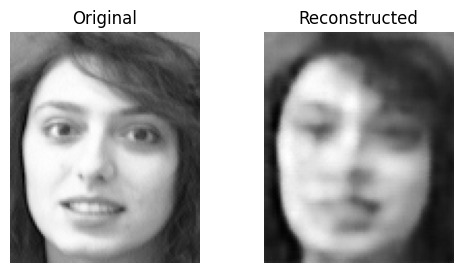

In [40]:
model.eval()

img = test_data[100]   
img.resize((112, 92))

# Prepare the image
img_tensor = torch.from_numpy(img).float()
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device)
img_tensor = img_tensor

# Forward pass
with torch.no_grad():
    _, reconstructed = model(img_tensor)

# Convert back to numpy
original_img = img_tensor.squeeze().cpu().numpy()
reconstructed_img = reconstructed.squeeze().cpu().numpy()

# Plot
plt.figure(figsize=(6,3))

# Original
plt.subplot(1,2,1)
plt.imshow(original_img, cmap='gray')
plt.title('Original')
plt.axis('off')

# Reconstructed
plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed')
plt.axis('off')

plt.show()

## **Extract Embedding Part**